In [103]:
import itertools
from functools import partial

import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import (buft_fill, form_affine_basis,
                         get_affine_transformation, make_like)
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               random_line_subdivide,
                               random_line_subdivide_gen,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.affinity import affine_transform
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [130]:
n_lines = 20
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin


des_xmin = xmin + width * 0.1
des_xmax = xmax - width * 0.1
des_xrange = (des_xmin, des_xmax)


init_rel_xs = np.linspace(0, 1, n_lines)

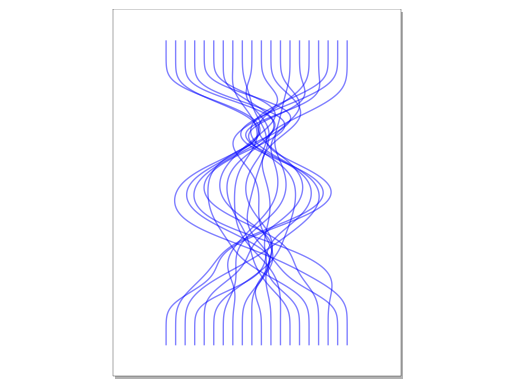

In [131]:
def get_ctrl_pts(x,):
    xs = [
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(-1, 2),
        np.random.uniform(0, 2),
        np.random.uniform(0, 2),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0.2, 0.8],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        
    ]
    xs = np.interp(xs, [0, 1], des_xrange,)
    ys = np.linspace(ymin, ymax, len(xs))
    return list(zip(xs, ys))


ctrl_pt_sets = [get_ctrl_pts(x) for x in init_rel_xs]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(mls)
sk.display()

In [132]:
buffed = [l.buffer(1.4, cap_style='round') for l in mls.geoms]

In [133]:
gdf = gpd.GeoDataFrame({'geometry': buffed})

In [128]:
n_centers = 3
center_ys = np.linspace(150, 250, n_centers)
center_xs = np.linspace(110, 170, n_centers)
radii = np.random.uniform(25, 180, n_centers)
thickness = np.random.uniform(1, 7, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness) for c, thickness in zip(circles, thickness)]

<Axes: >

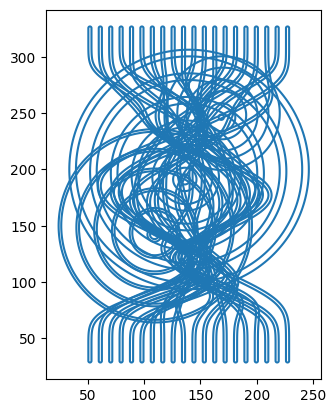

In [134]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -14))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills)]).explode(index_parts=False).reset_index(drop=True)
combined.boundary.plot()

In [135]:
disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 35 polygons
912 intersections remaining
Chunking polygons
Partitioning 4 chunks


4it [00:00, 22.23it/s]


Iteration 1 complete, 138 polygons remaining
Iteration 2
Finding intersections in 138 polygons
2210 intersections remaining
Chunking polygons
Partitioning 14 chunks


14it [00:02,  5.02it/s]


Iteration 2 complete, 743 polygons remaining
Iteration 3
Finding intersections in 743 polygons
3454 intersections remaining
Chunking polygons
Partitioning 58 chunks


58it [00:04, 13.62it/s]


Iteration 3 complete, 1362 polygons remaining
Iteration 4
Finding intersections in 1362 polygons
3596 intersections remaining
Chunking polygons
Partitioning 98 chunks


98it [00:05, 16.37it/s]


Iteration 4 complete, 1782 polygons remaining
Iteration 5
Finding intersections in 1782 polygons
2962 intersections remaining
Chunking polygons
Partitioning 114 chunks


114it [00:05, 20.59it/s]


Iteration 5 complete, 1760 polygons remaining
Iteration 6
Finding intersections in 1760 polygons
1942 intersections remaining
Chunking polygons
Partitioning 94 chunks


94it [00:04, 21.48it/s]


Iteration 6 complete, 1297 polygons remaining
Iteration 7
Finding intersections in 1297 polygons
984 intersections remaining
Chunking polygons
Partitioning 55 chunks


55it [00:03, 16.81it/s]


Iteration 7 complete, 718 polygons remaining
Iteration 8
Finding intersections in 718 polygons
436 intersections remaining
Chunking polygons
Partitioning 28 chunks


28it [00:01, 18.74it/s]


Iteration 8 complete, 352 polygons remaining
Iteration 9
Finding intersections in 352 polygons
152 intersections remaining
Chunking polygons
Partitioning 11 chunks


11it [00:00, 26.35it/s]


Iteration 9 complete, 123 polygons remaining
Iteration 10
Finding intersections in 123 polygons
46 intersections remaining
Chunking polygons
Partitioning 4 chunks


4it [00:00, 23.22it/s]


Iteration 10 complete, 42 polygons remaining
Iteration 11
Finding intersections in 42 polygons
6 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 47.45it/s]

Iteration 11 complete, 5 polygons remaining
Iteration 12
Finding intersections in 5 polygons
0 intersections remaining
Chunking polygons


In [136]:
disjoint = find_parent_polygons(disjoint=disjoint, original=combined)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [153]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-4
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

In [154]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
# idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)

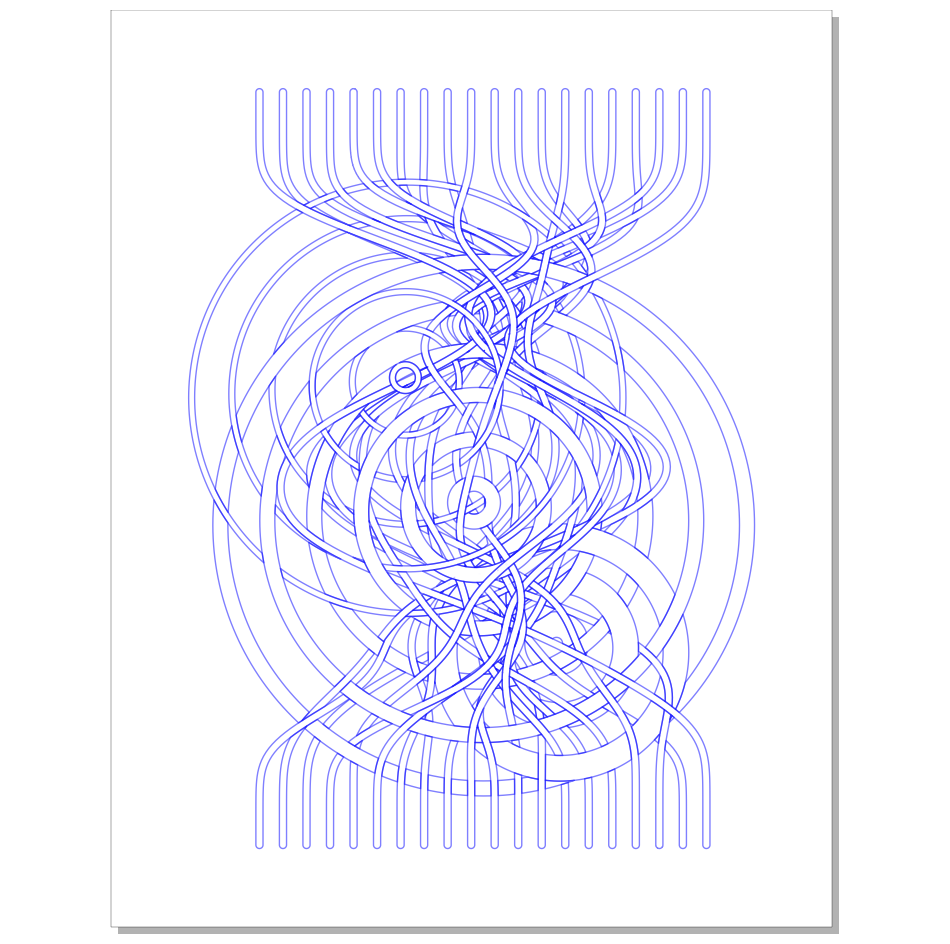

In [155]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [156]:
fills = []
for geom in combined.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary)
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [157]:
sampled_ngdf = ngdf.sample(frac=1., replace=False)

In [158]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
    masked.append(mask.boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

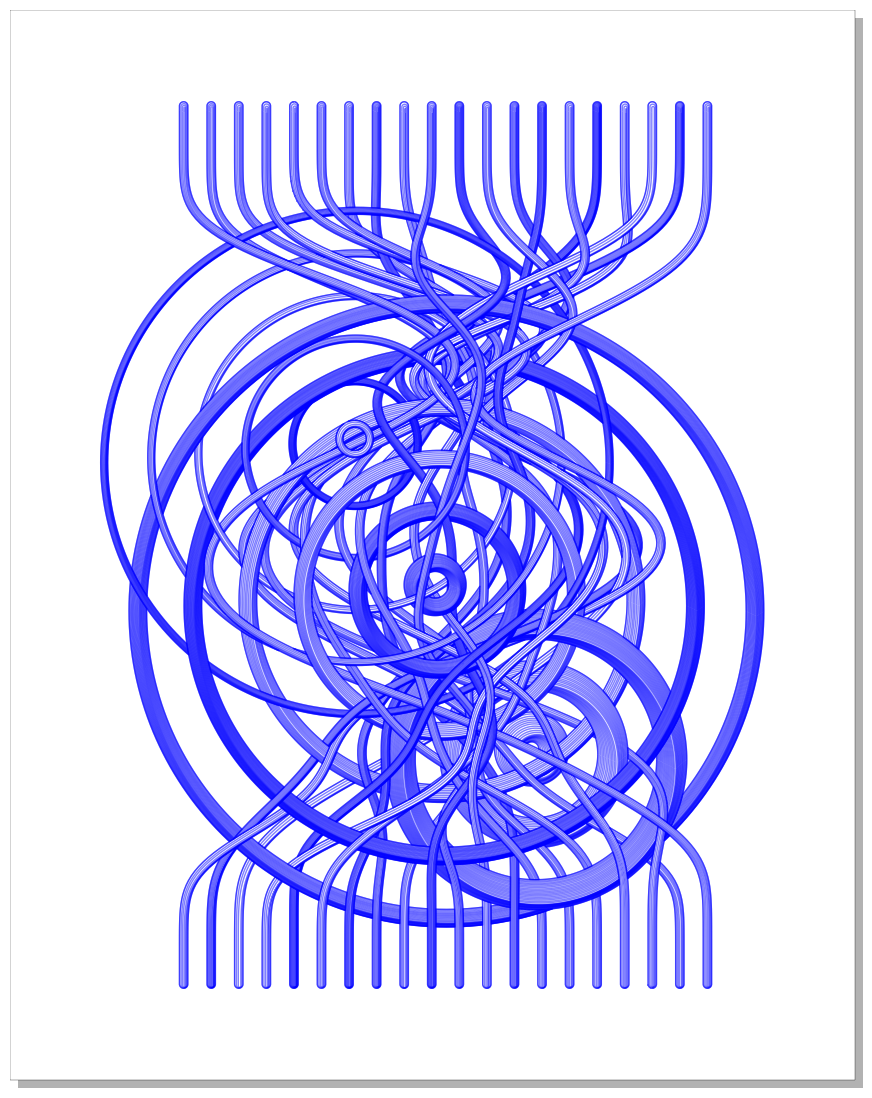

In [159]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display(fig_size=(11, 14))

In [160]:
sk.vpype('linesort')

In [161]:
fp = new_savepath(postfix='weave_and_circles_filled')
sk.save(fp)

In [40]:
x0s = np.linspace(0.1, 0.2, 10)
x1s = x0s + 0.5
xpairs = Prm(list(zip(x0s, x1s)), iterate=False)

In [41]:
geom = drawbox

In [42]:
lsdf = gpd.GeoDataFrame(geometry=[LineString([geom.boundary.interpolate(x, normalized=True) for x in xpair]) for xpair in xpairs()])

<Axes: >

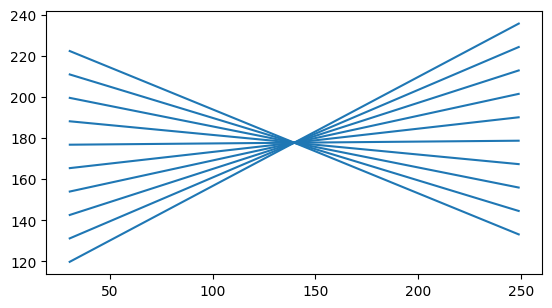

In [43]:
lsdf.plot()

<Axes: >

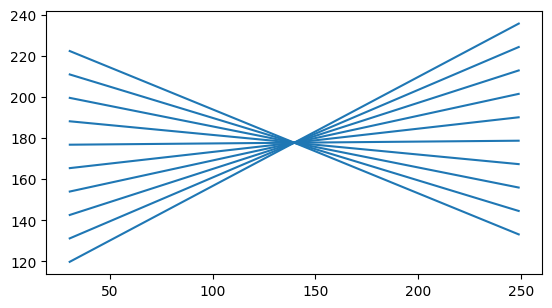

In [194]:
lsdf.plot()

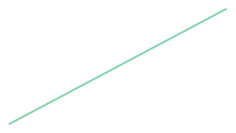

In [191]:
row.geometry

In [200]:
geoms = []
for ii, row in lsdf.iterrows():
    f = get_affine_transformation(row.geometry, longest_dim_first=False)
    # g = bezier_func([(0., 0), (.25, 0), (.5, np.random.uniform(-1, 1)), (.75, 0), (1, 0)])
    g = bezier_func([(0., 0.), (0, 0.25), (np.random.uniform(-1, 1), 0.5), (0, .75), (0., 1)])
    
    geoms.append(f(g(np.linspace(0, 1, 100))))
    # geoms.append(f(LineString([Point(0, 0), Point(1, 0)])))

<Axes: >

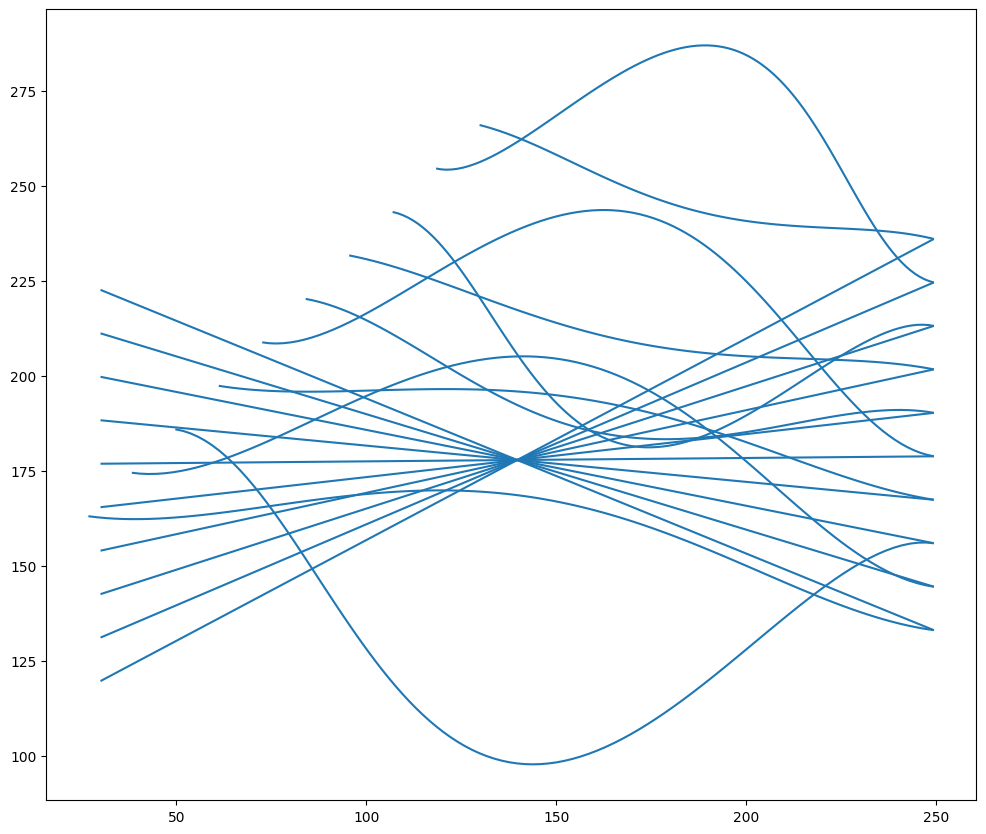

In [201]:
f,ax = plt.subplots(1,1, figsize=(12,12))
lsdf.plot(ax=ax)
gpd.GeoDataFrame(geometry=geoms).plot(ax=ax)

<Axes: >

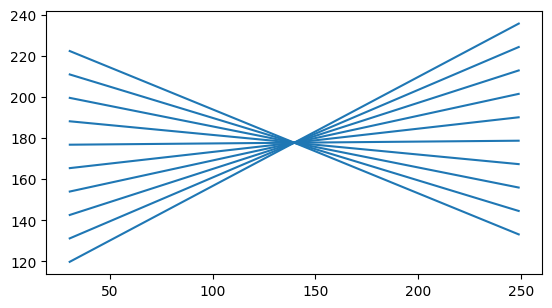

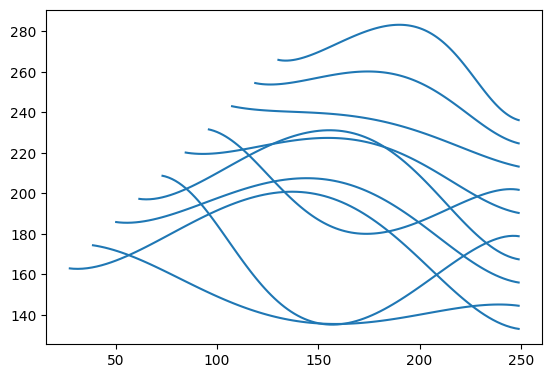

In [197]:
lsdf.plot()

In [178]:
x = np.array([0, 1])

In [181]:
x[::-1]

array([1, 0])

In [99]:
f = get_affine_transformation(row.geometry, longest_dim_first=True)
np.array(row.geometry)

array(<LINESTRING (249.4 236, 30 119.6)>, dtype=object)

In [184]:
row_geometry = LineString([(0, 0), (1, 2)])
f = get_affine_transformation(row_geometry, longest_dim_first=True)

transformed_line = f(LineString([Point(0, 0), Point(1, 0)]))
print(transformed_line)

LINESTRING (0 0, 1.0000000000000002 2)


In [176]:
row_geometry = LineString([(0, 0), (1, 2)])
f = get_affine_transformation(row_geometry, longest_dim_first=False)

transformed_line = f(LineString([Point(0, 0), Point(1, 0)]))
print(transformed_line)

LINESTRING (0 0, 1.0000000000000002 2)


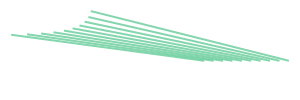

In [84]:
MultiLineString(geoms)

# comp

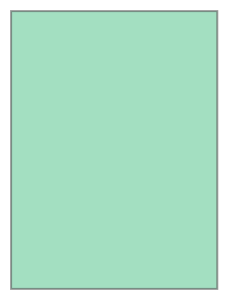

In [202]:
drawbox

In [426]:
phi = (1 + 5 ** 0.5) / 2
xgen = Prm(1/phi)
ngs = []
# geoms = split_along_longest_side_of_min_rectangle(drawbox, xgen=xgen)
# ngs.append(geoms.geoms[0])
# geoms = split_along_longest_side_of_min_rectangle(geoms.geoms[1], xgen=xgen)
# ngs.append(geoms.geoms[0])
# geoms = split_along_longest_side_of_min_rectangle(geoms.geoms[1], xgen=xgen)
# ngs.append(geoms.geoms[0])
split_func = partial(split_along_longest_side_of_min_rectangle, xgen=xgen)

continue_func = partial(bino_draw, p_continue=0.97)
small_geoms = flex_rule_recursive_split(poly=drawbox, split_func=split_func, continue_func=continue_func, depth=0, depth_limit=15)
ngs.extend(small_geoms)

In [437]:
gdf = gpd.GeoDataFrame(geometry=ngs)

gdf.geometry = gdf.geometry.buffer(-1)
gdf = gdf[~gdf.geometry.is_empty]

<Axes: >

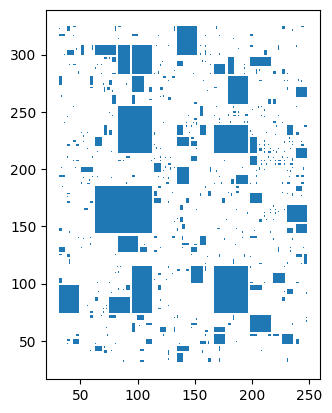

In [438]:
gdf.plot()

In [230]:
drawbox.bounds

(30.0, 30.0, 249.39999999999998, 325.59999999999997)

In [428]:
circle_bottom = Point(150, -40).buffer(400, resolution=64)
circle_right = Point(280, 200).buffer(400, resolution=64)
circles = [circle_bottom, circle_right]
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-40, -21))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)

In [432]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-34, -20))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    
    for fill in polys.boundary.geoms:
        fill = fill.buffer(np.random.uniform(5, 10), resolution=64)
        fills.append(fill)
    

In [433]:
fdf = gpd.GeoDataFrame(geometry=fills).explode(index_parts=False).reset_index(drop=True)

<Axes: >

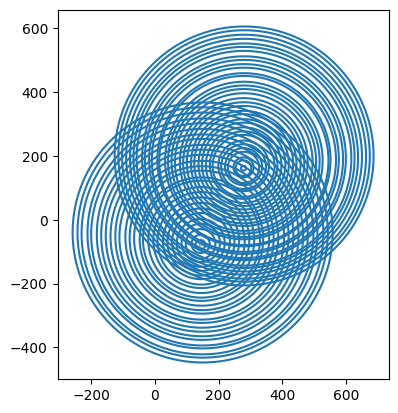

In [434]:
fdf.boundary.plot()

In [435]:
# gdf.loc[:, 'group'] = 0
# gdf.loc[1, 'group'] = 1
# gdf.loc[2, 'group'] = 0
# gdf.loc[3:, 'group'] 

In [436]:
# gdf.loc[3:, 'group'] = np.random.choice([0, 1], len(gdf.loc[3:]))

In [349]:
g0 = unary_union(gdf.query('group == 1').geometry)

In [350]:
dfdf = fdf.difference(g0)
dfdf =gpd.GeoDataFrame(dict(geometry=dfdf, group=2))

In [351]:
dgdf = gdf.query('group == 1').difference(unary_union(fdf.geometry))
dgdf = dgdf[~dgdf.is_empty].explode(index_parts=False).reset_index(drop=True)
dgdf = gpd.GeoDataFrame(dict(geometry=dgdf, group=1))

In [372]:
cdf = pd.concat([gdf, fdf]).reset_index(drop=True)

<Axes: >

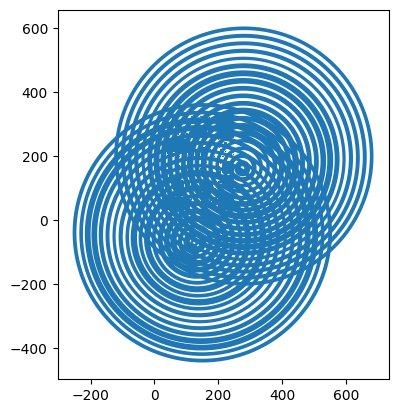

In [402]:
cdf.plot()

In [439]:
bcdf = cdf.intersection(drawbox)
bcdf = bcdf[~bcdf.is_empty].reset_index(drop=True)
bcdf = gpd.GeoDataFrame(dict(geometry=bcdf))

In [440]:
bbcdf = cdf.intersection(drawbox.buffer(50))
bbcdf = bbcdf[~bbcdf.is_empty].reset_index(drop=True)
bbcdf = gpd.GeoDataFrame(dict(geometry=bbcdf))

In [441]:
disjoint = chunked_pairwise_partition_polygons(
    bbcdf, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

Iteration 1
Finding intersections in 1292 polygons
4150 intersections remaining
Chunking polygons
Partitioning 119 chunks


119it [00:02, 47.14it/s] 


Iteration 1 complete, 1261 polygons remaining
Iteration 2
Finding intersections in 1261 polygons
3926 intersections remaining
Chunking polygons
Partitioning 122 chunks


122it [00:03, 37.80it/s] 


Iteration 2 complete, 1339 polygons remaining
Iteration 3
Finding intersections in 1339 polygons
3472 intersections remaining
Chunking polygons
Partitioning 119 chunks


119it [00:04, 29.73it/s]


Iteration 3 complete, 1359 polygons remaining
Iteration 4
Finding intersections in 1359 polygons
2968 intersections remaining
Chunking polygons
Partitioning 112 chunks


112it [00:03, 29.92it/s]


Iteration 4 complete, 1333 polygons remaining
Iteration 5
Finding intersections in 1333 polygons
2436 intersections remaining
Chunking polygons
Partitioning 102 chunks


102it [00:03, 27.65it/s]


Iteration 5 complete, 1244 polygons remaining
Iteration 6
Finding intersections in 1244 polygons
1812 intersections remaining
Chunking polygons
Partitioning 85 chunks


85it [00:03, 24.90it/s]


Iteration 6 complete, 1016 polygons remaining
Iteration 7
Finding intersections in 1016 polygons
1202 intersections remaining
Chunking polygons
Partitioning 60 chunks


60it [00:02, 23.85it/s]


Iteration 7 complete, 731 polygons remaining
Iteration 8
Finding intersections in 731 polygons
730 intersections remaining
Chunking polygons
Partitioning 41 chunks


41it [00:01, 22.63it/s]


Iteration 8 complete, 459 polygons remaining
Iteration 9
Finding intersections in 459 polygons
378 intersections remaining
Chunking polygons
Partitioning 21 chunks


21it [00:00, 22.27it/s]


Iteration 9 complete, 259 polygons remaining
Iteration 10
Finding intersections in 259 polygons
192 intersections remaining
Chunking polygons
Partitioning 13 chunks


13it [00:00, 29.60it/s]


Iteration 10 complete, 137 polygons remaining
Iteration 11
Finding intersections in 137 polygons
96 intersections remaining
Chunking polygons
Partitioning 7 chunks


7it [00:00, 24.31it/s]


Iteration 11 complete, 71 polygons remaining
Iteration 12
Finding intersections in 71 polygons
44 intersections remaining
Chunking polygons
Partitioning 3 chunks


3it [00:00, 19.55it/s]


Iteration 12 complete, 33 polygons remaining
Iteration 13
Finding intersections in 33 polygons
14 intersections remaining
Chunking polygons
Partitioning 2 chunks


2it [00:00, 39.32it/s]


Iteration 13 complete, 12 polygons remaining
Iteration 14
Finding intersections in 12 polygons
2 intersections remaining
Chunking polygons
Partitioning 1 chunks


1it [00:00, 80.89it/s]

Iteration 14 complete, 2 polygons remaining
Iteration 15
Finding intersections in 2 polygons
0 intersections remaining
Chunking polygons


In [442]:
disjoint = find_parent_polygons(disjoint=disjoint, original=bbcdf)
disjoint = assign_random_order_to_adjacent_clusters(disjoint)

In [443]:
ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-3
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

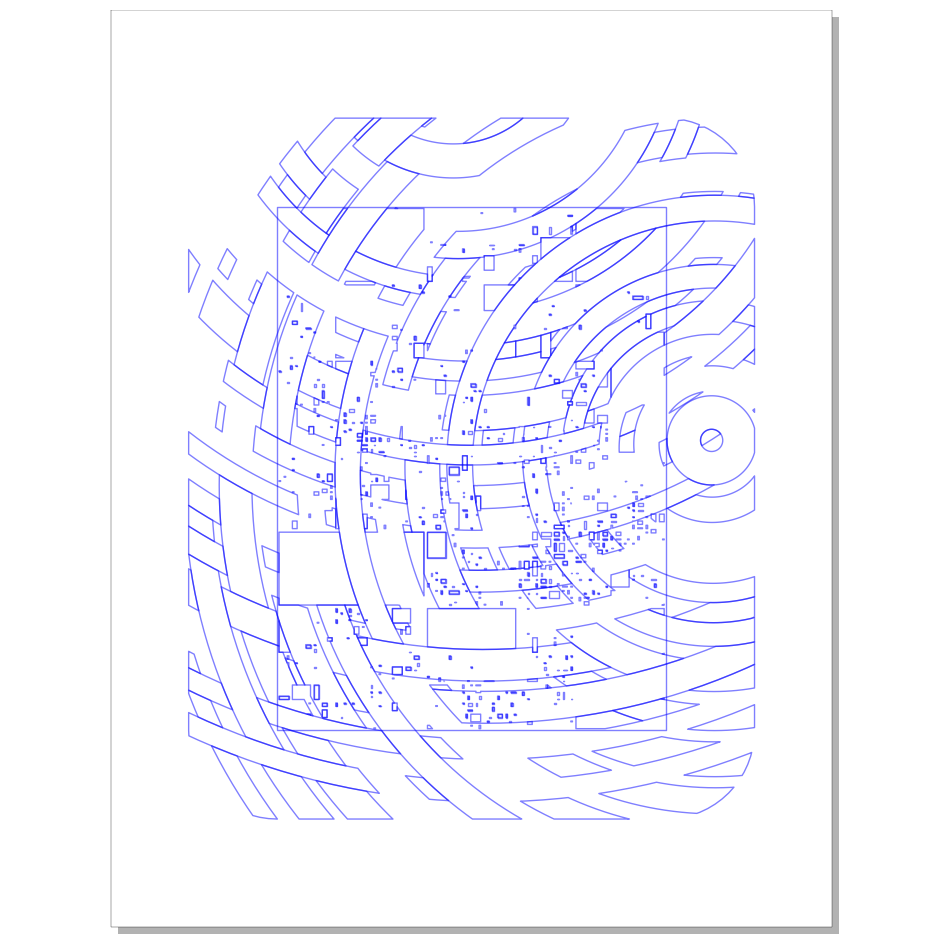

In [469]:
ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]
sampled_ngdf = ngdf.sample(frac=0.6, replace=False)
lss = [p.boundary for p in sampled_ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss + [drawbox.boundary])


sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))

In [470]:
fills = []
for geom in bbcdf.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.2))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary.intersection(drawbox))
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [471]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    _fill = fill.intersection(mask)
    masked.append(_fill)
    masked.append(mask.intersection(drawbox).boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

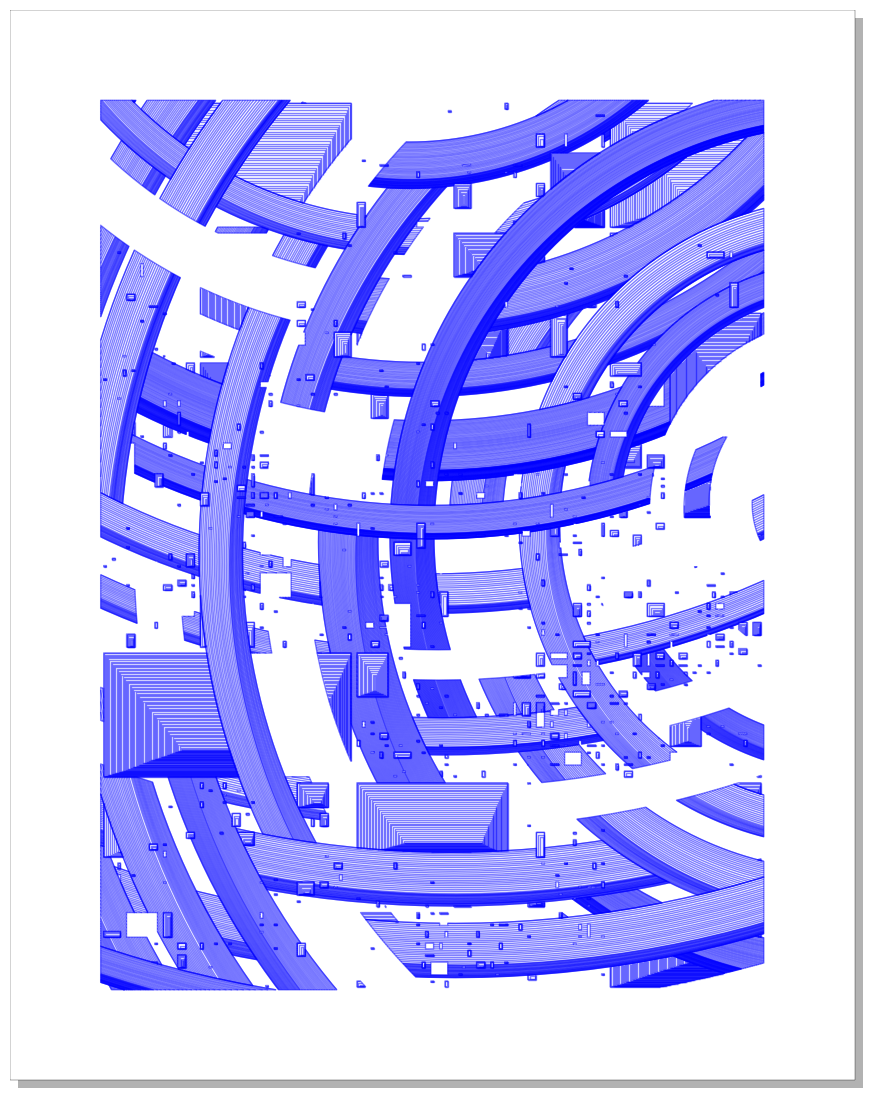

In [472]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display(fig_size=(11, 14))

In [473]:
sk.vpype('linesort')

In [474]:
fp = new_savepath(postfix='circles_and_subdivides_filled')
sk.save(fp)

/Users/alexandernaka/Library/Caches/pypoetry/virtualenvs/dashing-J-UKP8fp-py3.10/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


<Axes: >

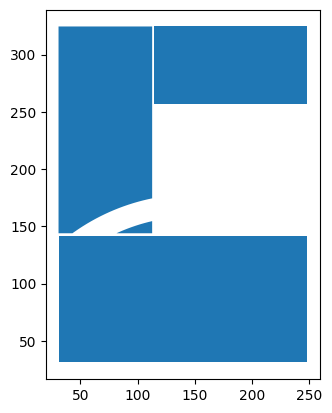

In [257]:
gdf.difference(fdf).reset_index(drop=True).plot()